# DataSets

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import DataSets as ds
import Layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Layers

In [3]:
class fc(tf.Module):
	def __init__(self, name, output_dim):
		self.scope_name = name
		self.output_dim = output_dim
		self.b = tf.Variable(tf.constant(0.0, shape=[self.output_dim]))
	def __call__(self, x, log_summary):
		if not hasattr(self, 'w'):
			w_init = tf.random.truncated_normal([x.shape[1], self.output_dim], stddev=0.1)
			self.w = tf.Variable(w_init)
			print('build fc %s  %d => %d' % (self.scope_name,  x.shape[1], self.output_dim))

		if log_summary:
			with tf.name_scope(self.scope_name) as scope:
				tf.summary.scalar("mean w", tf.reduce_mean(self.w))
				tf.summary.scalar("max w", tf.reduce_max(self.w))
				tf.summary.histogram("w", self.w)
				tf.summary.scalar("mean b", tf.reduce_mean(self.b))
				tf.summary.scalar("max b", tf.reduce_max(self.b))
				tf.summary.histogram("b", self.b)
		return tf.matmul(x, self.w) + self.b

In [4]:
class conv(tf.Module):
	def __init__(self, name, output_dim, filterSize, stride):
		self.scope_name = name
		self.filterSize = filterSize
		self.output_dim = output_dim
		self.stride = stride
		self.b = tf.Variable(tf.constant(0.0, shape=[self.output_dim]))
	def __call__(self, x, log_summary):
		if not hasattr(self, 'w'):
			w_init = tf.random.truncated_normal([self.filterSize, self.filterSize, x.shape[3], self.output_dim], stddev=0.1)
			self.w = tf.Variable(w_init)
			print('build conv %s %dx%d  %d => %d'%(self.scope_name,self.filterSize,self.filterSize, x.shape[3], self.output_dim))
		if log_summary:
			with tf.name_scope(self.scope_name) as scope:
				tf.summary.scalar("mean w", tf.reduce_mean(self.w))
				tf.summary.scalar("max w", tf.reduce_max(self.w))
				tf.summary.histogram("w", self.w)
				tf.summary.scalar("mean b", tf.reduce_mean(self.b))
				tf.summary.scalar("max b", tf.reduce_max(self.b))
				tf.summary.histogram("b", self.b)
		x = tf.nn.conv2d(x, self.w, strides=[1, self.stride, self.stride, 1], padding='SAME') + self.b
		return tf.nn.relu(x)

In [5]:
class maxpool(tf.Module):
	def __init__(self, name, poolSize):
		self.scope_name = name
		self.poolSize = poolSize

	def __call__(self, x):
		return tf.nn.max_pool2d(x, ksize=(1, self.poolSize, self.poolSize, 1),
								strides=(1, self.poolSize, self.poolSize, 1), padding='SAME')

In [6]:
class flat(tf.Module):
	def __call__(self, x):
		inDimH = x.shape[1]
		inDimW = x.shape[2]
		inDimD = x.shape[3]
		return tf.reshape(x, [-1, inDimH * inDimW * inDimD])

In [7]:
class unflat(tf.Module):
	def __init__(self, name, outDimH, outDimW, outDimD):
		self.scope_name = name
		self.new_shape = [-1, outDimH, outDimW, outDimD]
		print('def unflat %s ? => %d %d %d' % (self.scope_name, outDimH, outDimW, outDimD))

	def __call__(self, x, log_summary):
		x = tf.reshape(x, self.new_shape)
		if log_summary:
			with tf.name_scope(self.scope_name) as scope:
				tf.summary.image('input', x, 5)
		return x

# Main

In [8]:
LoadModel = True

experiment_size = 100

train = ds.DataSet('../Databases/data_%dk.bin'%experiment_size,'../Databases/gender_%dk.bin'%experiment_size,1000*experiment_size)

test = ds.DataSet('../Databases/data_test10k.bin','../Databases/gender_test10k.bin',10000)

nb data =  100000
nb data =  10000


## Construction du réseau CNN

In [9]:
class ConvNeuralNet(tf.Module):
	def __init__(self):
		self.unflat = Layers.unflat('unflat',48, 48, 1)
		self.cv1 = Layers.conv('conv_1', output_dim=3, filterSize=3, stride=1)
		self.mp = Layers.maxpool('pool', 2)
		self.cv2 = Layers.conv('conv_2', output_dim=6, filterSize=3, stride=1)
		self.cv3 = Layers.conv('conv_3', output_dim=12, filterSize=3, stride=1)
		self.flat = Layers.flat()
		self.fc = Layers.fc('fc', 2)

	def __call__(self, x, log_summary):
		x = self.unflat(x, log_summary)
		x = self.cv1(x, log_summary)
		x = self.mp(x)
		x = self.cv2(x, log_summary)
		x = self.mp(x)
		x = self.cv3(x, log_summary)
		x = self.mp(x)
		x = self.flat(x)
		x = self.fc(x, log_summary)
		return x

In [10]:
def train_one_iter(model, optimizer, image, label, log_summary):
	with tf.GradientTape() as tape:
		y = model(image,log_summary)
		y = tf.nn.log_softmax(y)
		diff = label * y
		loss = -tf.reduce_sum(diff)
		if log_summary:
			tf.summary.scalar('cross entropy', loss)
		grads = tape.gradient(loss, model.trainable_variables)
		optimizer.apply_gradients(zip(grads, model.trainable_variables))
	return loss

In [11]:
print ("-----------------------------------------------------")
print ("----------------------- %dk -------------------------"%experiment_size)
print ("-----------------------------------------------------")

train_summary_writer = tf.summary.create_file_writer('logs %dk'%experiment_size)
optimizer = tf.optimizers.Adam(1e-3)
simple_cnn = ConvNeuralNet()

-----------------------------------------------------
----------------------- 100k -------------------------
-----------------------------------------------------
def unflat unflat ? => 48 48 1


In [12]:
if LoadModel:
	ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn)
	ckpt.restore('./saved_model-1')

In [29]:
for iter in range(1000):
	tf.summary.experimental.set_step(iter)

	if iter % 500 == 0:
		with train_summary_writer.as_default():
			acc1 = train.mean_accuracy(simple_cnn) * 100
			acc2 = test.mean_accuracy(simple_cnn) * 100
			print("iter= %6d accuracy - train= %.2f%% - test= %.2f%%" % (iter, acc1, acc2))

	ima, lab = train.NextTrainingBatch()
	with train_summary_writer.as_default():
		loss = train_one_iter(simple_cnn, optimizer, ima, lab, iter % 10 == 0)
	if iter % 100 == 0:
		print("iter= %6d - loss= %f" % (iter, loss))

iter=      0 accuracy - train= 81.37% - test= 80.28%
iter=      0 - loss= 45.223297
iter=    100 - loss= 358.860962
iter=    200 - loss= 488.049591
iter=    300 - loss= 86.234566
iter=    400 - loss= 186.023407
iter=    500 accuracy - train= 56.91% - test= 54.34%
iter=    500 - loss= 570.728149
iter=    600 - loss= 189.260757
iter=    700 - loss= 227.979950
iter=    800 - loss= 520.391602
iter=    900 - loss= 505.286194


In [30]:
if not LoadModel:
	ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn)
	ckpt.save('./saved_model')

### Import Image

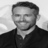

In [34]:
ima_init = Image.open("homme.png").convert('L')
ima_init

In [35]:
#ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer, net = simple_cnn)
#ckpt.restore('./saved_model-1')

In [36]:
test.mean_accuracy(simple_cnn)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5434>

### Preprocess image

In [37]:
ima = np.array(ima_init,dtype=np.float32).reshape([1, 2304])
ima = (ima - 128.0) / 256.0
pred = tf.nn.softmax(simple_cnn(ima,False))
pred.numpy()

array([[9.9996948e-01, 3.0501706e-05]], dtype=float32)

### Mislead CNN detector

In [38]:
X = tf.constant(ima)  #Creates a constant tensor from a tensor-like object.
X

<tf.Tensor: shape=(1, 2304), dtype=float32, numpy=
array([[ 0.40625   ,  0.40625   ,  0.40625   , ..., -0.390625  ,
        -0.40625   , -0.42578125]], dtype=float32)>

In [20]:
DXinit = tf.constant(0.0, shape=[1,2304])
DX = tf.Variable(DXinit)
DX

<tf.Variable 'Variable:0' shape=(1, 2304) dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [21]:
#load a wrong label
wrong_label = [0.0,1.0]
wrong_label

[0.0, 1.0]

In [22]:
# Add a Variable DX to the input in your graph
DXinit = tf.constant(0.0, shape=[1,2304])
DX = tf.Variable(DXinit)
Xmod = X + DX

In [23]:
# Train only the DX Variable
tf.nn.log_softmax(simple_cnn(DX,False)).numpy()
optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.1)

In [24]:
#Show Modified Image and DX Image
modified_img = Image.fromarray(np.reshape((Xmod).numpy(),(48,48)))
DX_img = Image.fromarray(np.reshape((DX).numpy(),(48,48)))

modified_img.show()
DX_img.show()

In [25]:
# Save the Modified Image. Xmod

modified_img.convert('L').save("Xmod.png")
modified_img.convert('L').save("DX.png")

In [26]:
# As DX is very small, build an amplified image.
A = abs(DX)*50
A_img = Image.fromarray(np.reshape(A.numpy(),(48,48)))
A_img.show()

In [27]:
# Test the Modified Image with your small script.

In [28]:
def noise_one_iter(model, optimizer, X,label):
    with tf.GradientTape() as tape:
        y = model(Xmod,False)
        y = tf.nn.log_softmax(y)
        diff = label * y
        loss = -tf.reduce_sum(diff)
        grads = tape.gradient(loss,[DX]) 
        optimizer.apply_gradients(zip(grads, [DX]))
    return loss

for iter in range(1000):
    with train_summary_writer.as_default():
        loss = noise_one_iter(simple_cnn, optimizer, X, wrong_label)
    if iter % 100 == 0:
        print("iter= %6d - loss= %f" % (iter, loss))

ValueError: No gradients provided for any variable: ["<tf.Variable 'Variable:0' shape=(1, 2304) dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>"].

In [ ]:
# Add an L2 constraint to DX to make it small
tf.nn.l2_loss([DX])

In [ ]:
with tf.GradientTape() as tape:
    y = simple_cnn(X+DX,False)
    y = tf.nn.log_softmax(y)
    diff = wrong_label * y
    loss = -tf.reduce_sum(diff)
    grads = tape.gradient(loss,[DX]) 
    optimizer.apply_gradients(zip(grads, [DX]))

In [ ]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.1)

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

